# Comparison Between Operator Learning and NTFields

### Setting Up the Environment

```bash
cd path/to/ntfields  # go to the ntfields directory, not the .ipynb
git submodule add https://github.com/YuliangXiu/bvh-distance-queries.git
conda env create -f NTFields_env.yml
conda activate NTFields
```

### Data Processing



To visualize path in a Gibson environment, run:

```eval
python test/gib_plan.py 
```

To sample random starts and goals in Gibson environments, run:

```eval
python test/sample_sg.py 
```

To show statistics results in Gibson environments, run:

```eval
python test/gib_stat.py 
```

In [1]:
import torch

''' Global Parameters '''
torch_device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Path Variables:
# model_path = './ntfields/Experiments/C3D'         
# data_path = './ntfields/datasets/c3d/0'
model_path = './ntfields/Experiments/PlanOp_3D'         
data_path = './ntfields/datasets/PlanOp_3D/3d_dataset_30x30x30'

# Training Booleans
is_load_pretrained = True
is_train = True  # Train Model

To prepare the 3D data:
1) Run one of the following commands in the cell below, such as...
    - ```python dataprocessing/preprocess.py --config ntfields/configs/PlanOp_3d.txt```
2) ```mkdir -p Experiments/PlanOp_3D```



In [16]:
import numpy as np
import open3d as o3d
import matplotlib.pyplot as plt

def plot_map(binary_map, map_num):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Identify and plot points where binary occupancy map is zero (obstacle)
    tolerance = 1e-6
    obs_indices = np.where(np.abs(binary_map - 0) < tolerance)
    ax.scatter(obs_indices[0], obs_indices[1], obs_indices[2], c='k', marker='o', label='Obstacles')
    # Set figure params
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title(f'Map #{map_num}')
    ax.legend()
    plt.show()

def separate_obstacles(scatter_points):
    """
    :param scatter_points: nx3 ndarray of all obstacle points
    :returns: dictionary with 8x3 ndarray of obstacle vertices in format [x, y, z]
    """
    filtered_x_obstacles = separate_by_x(scatter_points)
    
    filtered_y_obstacles = []
    for an_obstacle in filtered_x_obstacles:
        filtered_y_obstacles.append(separate_by('y', an_obstacle))
 
    filtered_z_obstacles = []
    for an_obstacle_list in filtered_y_obstacles:
        for some_obstacle in an_obstacle_list:
            filtered_z_obstacles.append(separate_by('z', some_obstacle))

    final_obstacle_list = []
    for an_obstacle_list in filtered_z_obstacles:
        for some_obstacle in an_obstacle_list:
            final_obstacle_list.append(some_obstacle)

    return final_obstacle_list

def separate_by_x(scatter_points):
    # Preallocate parameters
    xyz_idx = 0  # [x=0, y=1, z=2]
    obstacle_list = []
    tolerance = 1.0 + (1e-6)

    first_point = scatter_points[0, :]  # set first point
    point_collection = first_point[None, ...]  # initialize point_collection
    scatter_points = scatter_points[1:, :]  # iterate through all other points excluding first point.

    for point in scatter_points:
        # Check x, y, z are each within one 
        if (np.abs(first_point[xyz_idx] - point[xyz_idx]) <= tolerance):  # and (np.abs(first_point[1] - point[1]) <= tolerance) and (np.abs(first_point[2] - point[2]) <= tolerance):
            point_collection = np.concatenate((point_collection, point[None, ...]), axis=0)
        else:
            obstacle_list.append(point_collection)  # save point collection
            point_collection = point[None, ...]
        # reset for next iteration
        first_point = point
    obstacle_list.append(point_collection)  # save point collection
    return obstacle_list

def separate_by(var, scatter_points):
    """ 
    """
    if var == 'y':
        xyz_idx = 1  # [x=0, y=1, z=2]
    elif var == 'z':
        xyz_idx = 2
    else:
        raise ValueError("Variable 'var' should only be 'y' or 'z'.")
    
    # First, find all (min, max) pairs so that each point can be assigned to the right obstacle
    min_max_pairs = []
    var_column = scatter_points[1:, xyz_idx]
    prev_var = scatter_points[0, xyz_idx]
    current_line_of_nums = [prev_var]
    tolerance = 1.0 + (1e-6)

    for some_idx, var_val in enumerate(var_column):
        # Check y_prev and y (or z_prev and z_ are each within distance of 1 of each other
        if (np.abs(prev_var - var_val) <= tolerance):  # and (np.abs(first_point[1] - point[1]) <= tolerance) and (np.abs(first_point[2] - point[2]) <= tolerance):
            current_line_of_nums.append(var_val)
        else:
            min_val = min(current_line_of_nums)
            max_val = max(current_line_of_nums)
            min_max_pair = (min_val, max_val)
            if len(min_max_pairs) != 0:
                # Determine if duplicate
                is_duplicate = False
                for a_pair in min_max_pairs:
                    if (a_pair == min_max_pair):
                        is_duplicate = True
                if not is_duplicate:
                    min_max_pairs.append(min_max_pair)
            else: # append first min/max pair
                min_max_pairs.append(min_max_pair)

            current_line_of_nums = [var_val]  # reset for next iteration
        # reset for next iteration
        prev_var = var_val

    # Preallocate parameters
    obstacle_list = [np.zeros((1, 3)) for _ in range(0, len(min_max_pairs))]
    for point in scatter_points:
        pair_found = False
        pair_idx = 0
        while (not pair_found) and (pair_idx < len(min_max_pairs)):
            var_min = min_max_pairs[pair_idx][0]
            var_max = min_max_pairs[pair_idx][1]
            if (point[xyz_idx] >= var_min) and (point[xyz_idx] <= var_max):
                pair_found = True
                obstacle_list[pair_idx] = np.concatenate((obstacle_list[pair_idx], point[None, ...]), axis=0)
            pair_idx = pair_idx + 1

    # Remove zeros from top level
    for obs_idx, obstacle in enumerate(obstacle_list):
        obstacle_list[obs_idx] = np.delete(obstacle, (0), axis=0)

    return obstacle_list
    

def create_obj_file(binary_map, map_num, file_path='./ntfields/datasets/PlanOp_3D/'):
    """
    :param binary_map: 30x30x30 binary occupancy grid; one of 6000 custom environments.
    :param map_num: integer 0-5999 for custom map data in 30x30x30 environments
    :param file_path: string defining path to save file
    :returns: 
    """

    # Identify and plot points where binary occupancy map is zero (obstacle)
    tolerance = 1e-6
    obs_scatter_points = np.where(np.abs(binary_map - 0) < tolerance)
    obs_scatter_points = np.stack((obs_scatter_points[0], obs_scatter_points[1], obs_scatter_points[2]), axis=0)
    obs_scatter_points = obs_scatter_points.transpose()

    obs_indices_dict = separate_obstacles(obs_scatter_points)

    # # Open .obj file for writing
    # map_obj_file = open(file=(file_path + 'map_num_' + str(map_num) + '.obj'), mode='w')
    # # Define Object name
    # file_data = "o cube_env_" + str(map_num) + "\n"
    # # Capture vertices in obstacle
    # for key, obstacle_vertex in obs_indices_dict.items():
    # # for obstacle_vertex in obs_scatter_points:
    #     file_data = file_data + 'v {0}, {1}, {2}\n'.format(obstacle_vertex[0],
    #                                                        obstacle_vertex[1],
    #                                                        obstacle_vertex[2])

    # # Define material as "Default"
    # file_data = file_data + 'usemtl Default\n'

    # # Define faces of obstacles
    # # for idx in range(0, len(obstacles)):
    # #     file_data = file_data + 'f {0} {1} {2} {3}\n'.format(4 + (6*idx), 3 + (6*idx), 2 + (6*idx), 1 + (6*idx))
    # #     file_data = file_data + 'f {0} {1} {2} {3}\n'.format(2 + (6*idx), 6 + (6*idx), 5 + (6*idx), 1 + (6*idx))
    # #     file_data = file_data + 'f {0} {1} {2} {3}\n'.format(3 + (6*idx), 7 + (6*idx), 6 + (6*idx), 2 + (6*idx))
    # #     file_data = file_data + 'f {0} {1} {2} {3}\n'.format(8 + (6*idx), 7 + (6*idx), 3 + (6*idx), 4 + (6*idx))
    # #     file_data = file_data + 'f {0} {1} {2} {3}\n'.format(5 + (6*idx), 8 + (6*idx), 4 + (6*idx), 1 + (6*idx))
    # #     file_data = file_data + 'f {0} {1} {2} {3}\n'.format(6 + (6*idx), 7 + (6*idx), 8 + (6*idx), 5 + (6*idx))
    
    # map_obj_file.write(file_data)


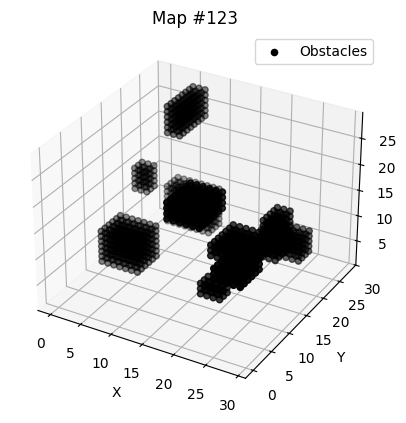

IndexError: index 0 is out of bounds for axis 0 with size 0

In [17]:
# Read 3D 30x30x30 grids
data_signed_dist = np.load(file=data_path + '/raw_binary_maps/dist_in.npy', allow_pickle=True)  # signed distance function data
data_goals = np.load(file=data_path + '/raw_binary_maps/goals.npy', allow_pickle=True)  # goals in various environments
data_mask = np.load(file=data_path + '/raw_binary_maps/mask.npy', allow_pickle=True)  # binary occupancy data
data_output = np.load(file=data_path + '/raw_binary_maps/output.npy', allow_pickle=True)  # 

# Sample 5 binary occupancy maps from data_mask
maps_to_sample = [123, 4568, 3264, 2567, 5555]  # 6000 possible choices

# Visualize the binary occupancy grid
for map_idx in maps_to_sample:
    # Scatter plot of binary occupancy grid for comparison
    bin_map = data_mask[map_idx, :, :, :]
    plot_map(bin_map, map_idx)
    # Create .obj file from binary occupancy map
    create_obj_file(bin_map, map_idx, data_path)


''' Uncomment the line you would like for data preparation '''
# !python ntfields/dataprocessing/preprocess.py --config ntfields/configs/c3d.txt
# !python ntfields/dataprocessing/preprocess.py --config ntfields/configs/PlanOp_3D.txt


### Training/Evaluation Loop Definition

In [ ]:
import sys
sys.path.append('./ntfields/models')
from model_3d import Model


model = Model(model_path, data_path, 3,[-0.4,-0], device=torch_device)
# if is_load_pretrained:
#     model.load(torch.load(model_path))

if is_train:
    model.train()
else:
    model.eval()
    with torch.no_grad():
        pass

In [ ]:
# Scratch Work Cell
model.Params['Device']

import gc

# clear memory
torch.cuda.empty_cache()
# del variables
gc.collect()


### Citation for NTFields

```
@inproceedings{
    ni2023ntfields,
    title={{NTF}ields: Neural Time Fields for Physics-Informed Robot Motion Planning},
    author={Ruiqi Ni and Ahmed H Qureshi},
    booktitle={International Conference on Learning Representations},
    year={2023},
    url={https://openreview.net/forum?id=ApF0dmi1_9K}
}
```

### NTFields License

NTFields is released under the MIT License. Please see below:

<em>
MIT License

Copyright (c) 2023 ruiqini

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.
</em>